NBEATS EXAMPLE

https://subhayo.wordpress.com/2019/05/15/time-series-analysis-of-monthly-milk-production/

It's a toy example to show how to do time series forecasting using N-Beats.

In [3]:
%matplotlib inline
import warnings
import sys
sys.path.append("../")
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from torch import optim
from torch.nn import functional as F

from nbeats_pytorch.model import NBeatsNet
from trainer_pytorch import save

warnings.filterwarnings(action='ignore', message='Setting attributes')

In [19]:
import pandas as pd

In [20]:
milk = pd.read_csv('data/milk.csv', index_col=0, parse_dates=True)

In [21]:
milk

,milk_production_pounds
month,
1962-01-01,589
1962-02-01,561
1962-03-01,640
1962-04-01,656
1962-05-01,727
...,...
1975-08-01,858
1975-09-01,817
1975-10-01,827


In [24]:
# plot utils.
def plot_scatter(*args, **kwargs):
    plt.plot(*args, **kwargs)
    plt.scatter(*args, **kwargs)


# simple batcher.
def data_generator(x, y, size):
    assert len(x) == len(y)
    batches = []
    for ii in range(0, len(x), size):
        batches.append((x[ii:ii + size], y[ii:ii + size]))
    for batch in batches:
        yield batch

In [10]:

forecast_length = 1
backcast_length = 23 * forecast_length
batch_size = 10  # greater than 4 for viz

milk = pd.read_csv('data/milk.csv', index_col=0, parse_dates=True)
print(milk.head())
milk = milk.values.flatten()  # just keep np array here for simplicity.

# data backcast/forecast generation.
x, y = [], []
for epoch in range(backcast_length, len(milk) - forecast_length):
    x.append(milk[epoch - backcast_length:epoch])
    y.append(milk[epoch:epoch + forecast_length])
x = np.array(x)
y = np.array(y)

# split train/test.
c = int(len(x) * 0.8)
x_train, y_train = x[:c], y[:c]
x_test, y_test = x[c:], y[c:]

            milk_production_pounds
month                             
1962-01-01                     589
1962-02-01                     561
1962-03-01                     640
1962-04-01                     656
1962-05-01                     727


In [13]:
x_train.shape

(115, 23)

In [12]:
y_train.shape

(115, 1)

            milk_production_pounds
month                             
1962-01-01                     589
1962-02-01                     561
1962-03-01                     640
1962-04-01                     656
1962-05-01                     727
| N-Beats
| --  Stack Generic (#0) (share_weights_in_stack=False)
     | -- GenericBlock(units=128, thetas_dim=4, backcast_length=1, forecast_length=1, share_thetas=False) at @6299859552
     | -- GenericBlock(units=128, thetas_dim=4, backcast_length=1, forecast_length=1, share_thetas=False) at @6300730944
     | -- GenericBlock(units=128, thetas_dim=4, backcast_length=1, forecast_length=1, share_thetas=False) at @6300730320
| --  Stack Generic (#1) (share_weights_in_stack=False)
     | -- GenericBlock(units=128, thetas_dim=8, backcast_length=1, forecast_length=1, share_thetas=False) at @6299858784
     | -- GenericBlock(units=128, thetas_dim=8, backcast_length=1, forecast_length=1, share_thetas=False) at @6300730848
     | -- GenericBlock(units

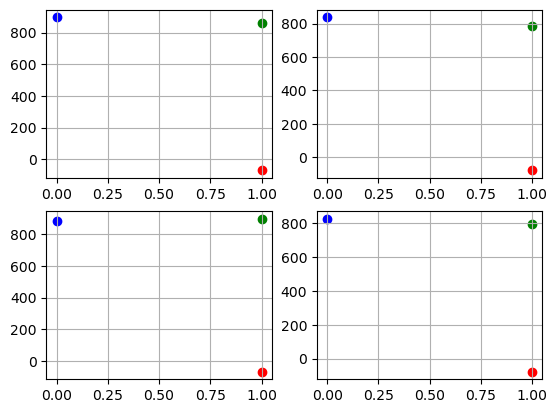

epoch = 0000, grad_step = 000014, tr_loss (epoch) = 1107.876, te_loss (epoch) = 937.653


KeyboardInterrupt: 

In [29]:

from nbeats_pytorch.model import NBeatsNet
def main():
    forecast_length = 1
    backcast_length = 1 * forecast_length
    batch_size = 10  # greater than 4 for viz

    milk = pd.read_csv('data/milk.csv', index_col=0, parse_dates=True)
    print(milk.head())
    milk = milk.values.flatten()  # just keep np array here for simplicity.

    # data backcast/forecast generation.
    x, y = [], []
    for epoch in range(backcast_length, len(milk) - forecast_length):
        x.append(milk[epoch - backcast_length:epoch])
        y.append(milk[epoch:epoch + forecast_length])
    x = np.array(x)
    y = np.array(y)

    # split train/test.
    c = int(len(x) * 0.8)
    x_train, y_train = x[:c], y[:c]
    x_test, y_test = x[c:], y[c:]

    # normalization.
    norm_constant = np.max(x_train)
    x_train, y_train = x_train / norm_constant, y_train / norm_constant
    x_test, y_test = x_test / norm_constant, y_test / norm_constant

    # model
    net = NBeatsNet(
        stack_types=(NBeatsNet.GENERIC_BLOCK, NBeatsNet.GENERIC_BLOCK),
        forecast_length=forecast_length,
        backcast_length=backcast_length,
        hidden_layer_units=128,
    )
    optimiser = optim.Adam(lr=1e-4, params=net.parameters())

    grad_step = 0
    for epoch in range(1000):
        # train.
        net.train()
        train_loss = []
        for x_train_batch, y_train_batch in data_generator(x_train, y_train, batch_size):
            grad_step += 1
            optimiser.zero_grad()
            _, forecast = net(torch.tensor(x_train_batch, dtype=torch.float).to(net.device))
            loss = F.mse_loss(forecast, torch.tensor(y_train_batch, dtype=torch.float).to(net.device))
            train_loss.append(loss.item())
            loss.backward()
            optimiser.step()
        train_loss = np.mean(train_loss)

        # test.
        net.eval()
        _, forecast = net(torch.tensor(x_test, dtype=torch.float))
        test_loss = F.mse_loss(forecast, torch.tensor(y_test, dtype=torch.float)).item()
        p = forecast.detach().numpy()
        if epoch % 100 == 0:
            subplots = [221, 222, 223, 224]
            plt.figure(1)
            for plot_id, i in enumerate(np.random.choice(range(len(x_test)), size=4, replace=False)):
                ff, xx, yy = p[i] * norm_constant, x_test[i] * norm_constant, y_test[i] * norm_constant
                plt.subplot(subplots[plot_id])
                plt.grid()
                plot_scatter(range(0, backcast_length), xx, color='b')
                plot_scatter(range(backcast_length, backcast_length + forecast_length), yy, color='g')
                plot_scatter(range(backcast_length, backcast_length + forecast_length), ff, color='r')
            plt.show()

            with torch.no_grad():
                save(net, optimiser, grad_step)
            print(f'epoch = {str(epoch).zfill(4)}, '
                  f'grad_step = {str(grad_step).zfill(6)}, '
                  f'tr_loss (epoch) = {1000 * train_loss:.3f}, '
                  f'te_loss (epoch) = {1000 * test_loss:.3f}')




if __name__ == '__main__':
    main()

In [7]:
symbols = ("SPY", "QQQ", "BND", "VNQ")
data = yf.download(symbols)

[*********************100%%**********************]  4 of 4 completed


In [9]:
import numpy as np

In [2]:
import mvarch

In [3]:
model = mvarch.model_factory(distribution="studentt", mean="zero", univariate="arch", constraint="none")

In [10]:
df = np.log1p(data.loc[:, ("Adj Close", symbols)].dropna().pct_change().dropna())

In [14]:
fit_history = df.values

In [12]:
model.fit(fit_history)

In [15]:

TAIL_SIZE = 500
evaluate_tail = df.index[-TAIL_SIZE:]
evaluate_history = df.loc[evaluate_tail].values
(
    mv_scale_predicted,
    uv_scale_predicted,
    mean_predicted,
    mv_scale_history,
    uv_scale_history,
    mean_history,
) = model.predict(evaluate_history)

# Show predicted next day volatilities and correlations:

print(
    f"Next day volatility prediction (annualized):\n"
    f"{(np.sqrt(252.) * uv_scale_predicted * model.distribution.std_dev()).numpy()}\n"
)

print(
    f"Next day correlation prediction:\n"
    f"{(mv_scale_predicted @ mv_scale_predicted.T).numpy()}"
)

Next day volatility prediction (annualized):
[0.10076555 0.1446409  0.05137579 0.17794609]

Next day correlation prediction:
[[1.         0.9171672  0.15659904 0.6057926 ]
 [0.9171672  1.         0.14140797 0.42485517]
 [0.15659904 0.14140797 0.9999999  0.3999394 ]
 [0.6057926  0.42485517 0.3999394  1.        ]]


In [16]:
df

Price      Adj Close                              
Ticker           SPY       QQQ       BND       VNQ
Date                                              
2007-04-11 -0.004088 -0.010575 -0.002663 -0.015010
2007-04-12  0.004434  0.007886 -0.000133 -0.006829
2007-04-13  0.004552  0.002018 -0.001601  0.011230
2007-04-16  0.009452  0.009140  0.000935  0.001254
2007-04-17  0.002655  0.002217  0.002530  0.012948
...              ...       ...       ...       ...
2024-01-22  0.002112  0.001305  0.001650  0.005954
2024-01-23  0.002912  0.004141 -0.002338 -0.006891
2024-01-24  0.001093  0.005534 -0.002068 -0.014402
2024-01-25  0.005424  0.001220  0.004681  0.012760
2024-01-26 -0.001271 -0.005975 -0.001512 -0.002822

[4229 rows x 4 columns]